In [1]:
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt

import HTC
import time

In [2]:
# Load connectome and normalize it
W=np.loadtxt("../Data/connectivity_matrix/weights.txt")
W=W/W.sum(axis=1)[:,None]

# Create brain object and set its parameters
brain=HTC.Brain(W)
n_neurons=brain.n_neurons
brain.set_netowrk_parameters(r1=2/n_neurons, r2=(2/n_neurons)**0.2, tc=0.15)

# Generate initial configuration with 10% active neurons
states_orig = HTC.generate_initial_conf(active_frac=0.1, n_neurons=brain.n_neurons, n_runs=50) # with random configurations

# Evolve over time the states (save every step in activity matrix)
n_timesteps=6000
n_runs=50
activity=np.zeros((n_runs,n_timesteps, brain.n_neurons)) #storing time, run and activity
states=states_orig

# Dummy adjustment of system
for t in range(100):
    states, _ = HTC.update_states(states=states,
                                            r1=brain.r1,
                                            r2= brain.r2,
                                            tc= 0.15,
                                            W= W)
# Real simulation
for t in range(n_timesteps):
    states, activity[:,t] = HTC.update_states(states=states,
                                            r1=brain.r1,
                                            r2= brain.r2,
                                            tc= 0.15,
                                            W= W)

In [3]:
sample_rate=1/0.1
nyquist_freq=sample_rate/2
a1=6
a2=12
b=0.9
c=0.35
d1=a1*b
d2=a2*b

time=np.arange(n_timesteps)/sample_rate
tt=np.arange(250)/sample_rate

hrf=((tt/d1)**a1)*np.exp(-(tt-d1)/b)-c*((tt/d2)**a2)*np.exp(-(tt-d2)/b)

In [4]:
# FIR filter
ntaps=21
band=[0.01/nyquist_freq,0.1/nyquist_freq]
delay = 0.5 * (ntaps-1) / sample_rate

filt_fir = signal.firwin(21, band,
                                 pass_zero=False, window='blackmanharris')

convolved_signals = np.array(
            [np.array(
                [np.convolve(activity[run, :, neuron], hrf, mode='same') for neuron in range(n_neurons)]) for run in range(n_runs)])


filtered_signals = np.array(
            [np.array(
                [np.convolve(convolved_signals[run, neuron, :], filt_fir, mode='valid') for neuron in range(n_neurons)]) for run in range(n_runs)])


<Figure size 432x288 with 0 Axes>

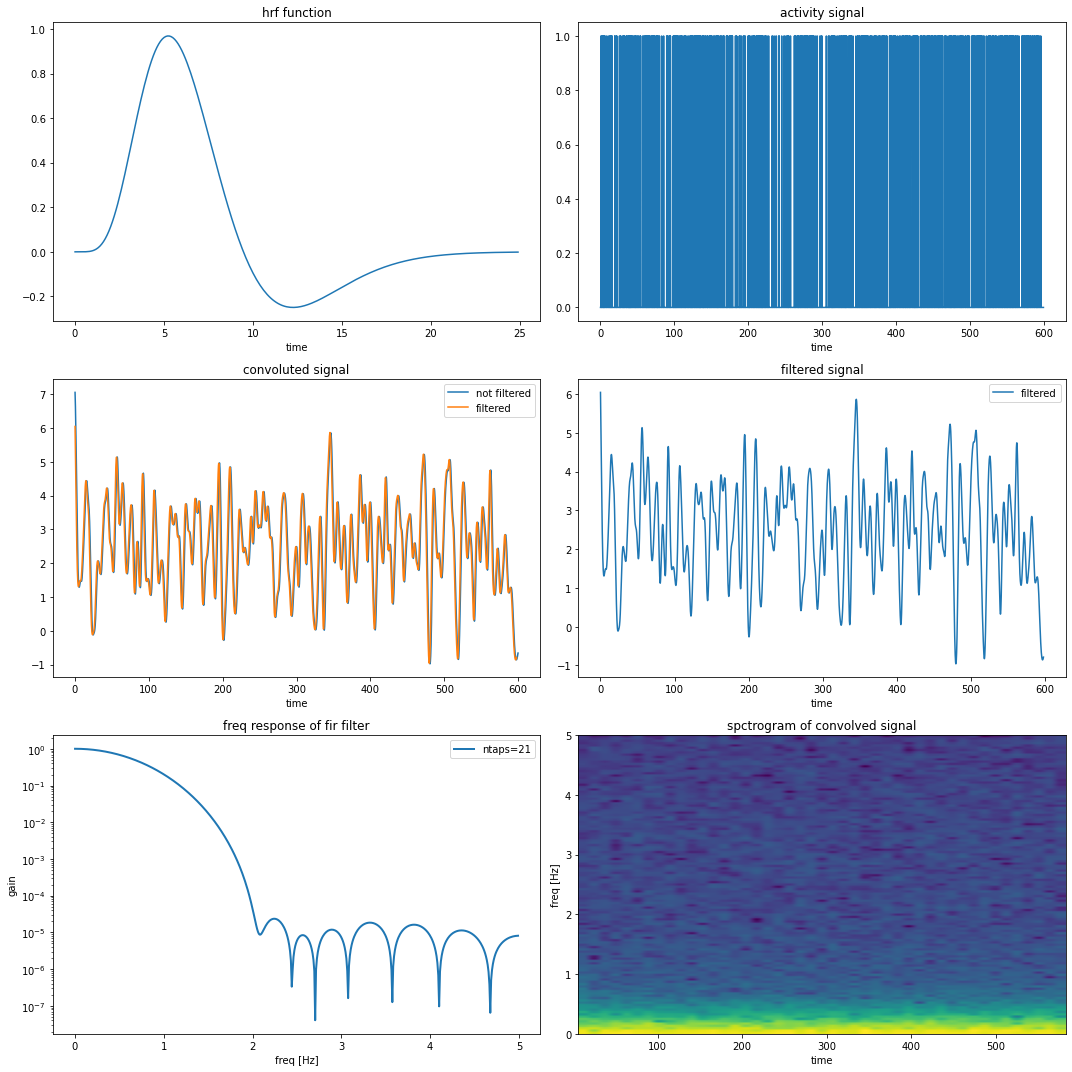

In [5]:
plt.figure(1)
plt.figure(figsize=(15,15))
x,y=3,2

plt.subplot(x,y,1)
plt.plot(tt,hrf)
plt.xlabel('time')
plt.title('hrf function')

plt.subplot(x,y,2)
plt.plot(time,activity[0,:,1])
plt.xlabel('time')
plt.title('activity signal')

plt.subplot(x,y,3)
plt.plot(time, convolved_signals[0,0,:], label='not filtered')
plt.plot(time[0:filtered_signals.shape[2]],filtered_signals[0,0,:], label='filtered')
plt.legend()
plt.xlabel('time')
plt.title('convoluted signal')

plt.subplot(x,y,4)
plt.plot(time[0:filtered_signals.shape[2]],filtered_signals[0,0,:], label='filtered')
plt.xlabel('time')
plt.legend()
plt.title('filtered signal')



plt.subplot(x,y,5)
w,h=signal.freqz(filt_fir)
plt.plot((w/np.pi)*nyquist_freq, np.absolute(h), linewidth=2, label='ntaps=%i'%len(filt_fir))
plt.legend()
plt.xlabel('freq [Hz]')
plt.ylabel('gain')
plt.title('freq response of fir filter')
plt.semilogy()

plt.subplot(x,y,6)
plt.specgram(convolved_signals[0,0,:],Fs=10)
plt.title('spctrogram of convolved signal')
plt.xlabel('time')
plt.ylabel('freq [Hz]')



plt.tight_layout()
plt.show()